# XAITK-Armory Adversarial Robustness Example <a name="XAITK-Saliency-Armory-Example"></a>
This notebook makes use of the adversarial patches generated from [here](https://colab.research.google.com/gist/christopherwoodall/8c25aebd5858304046d5ff9a93d5b95d/running_armory_scenarios_interactively.ipynb), and explores generating saliency maps on the patches using ``xaitk-saliency``.

In [ ]:
import sys
!{sys.executable} -m pip install -qU pip
!{sys.executable} -m pip install -q xaitk-saliency
!{sys.executable} -m pip install -q torch
!{sys.executable} -m pip install -q torchvision

## Test Image <a name="Test-Image-XAITK-Armory"></a>

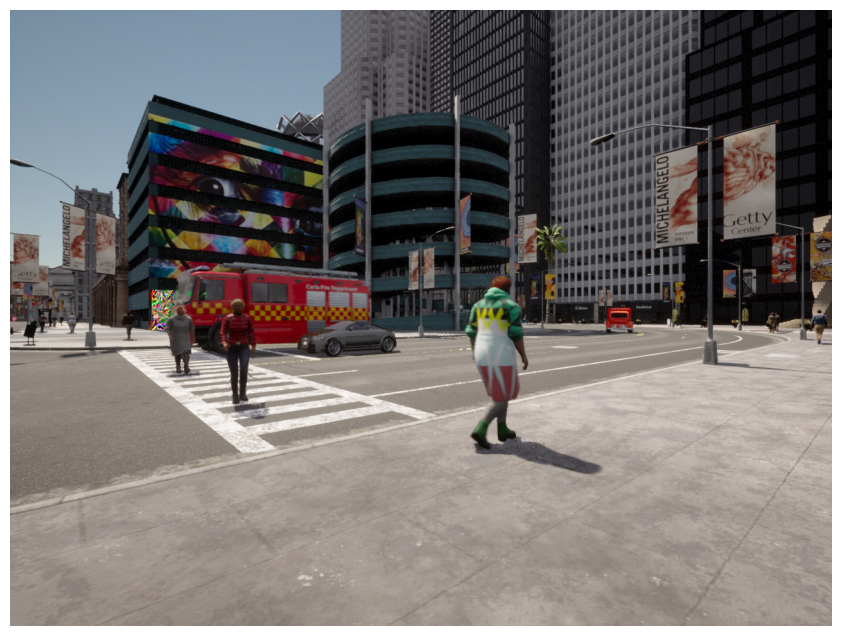

In [1]:
import os
import PIL.Image
import matplotlib.pyplot as plt
import urllib.request

# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "png"

os.makedirs('data/adversarial-patches', exist_ok=True)
test_image_filename = 'data/adversarial-patches/adversarial_batch_1.png'
plt.figure(figsize=(12, 8))
plt.axis('off')
target = PIL.Image.open(test_image_filename)
_ = plt.imshow(target)

## Load Custom SMQTK wrapped Armory FRCNN model <a name="Load-Model-XAITK-Armory"></a>

In [2]:
from armory_smqtk_detect_objects import ResNetFRCNN

detector = ResNetFRCNN(
    box_thresh=0.5,
    img_batch_size=1,
    use_cuda=True
)

## Generate and Visualize Model Detections <a name="Generate-Detections-XAITK-Armory"></a>

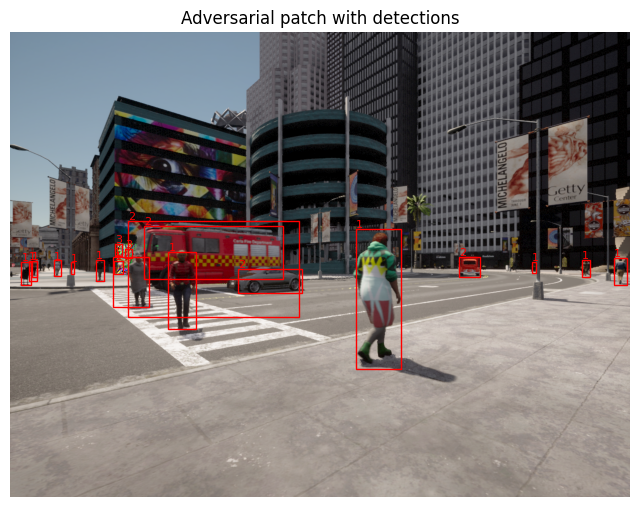

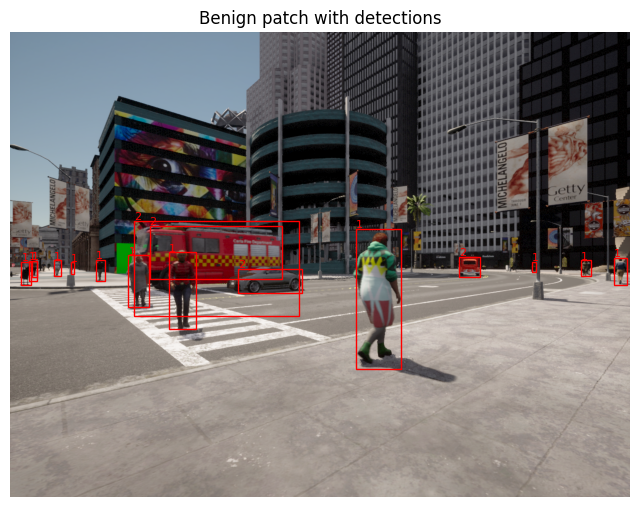

In [3]:
import numpy as np
from matplotlib.patches import Rectangle

class_ids = {'person': '1', 'vehicle': '2', 'traffic light':'3'}

def show_dets(ax, dets, thresh=0.5, show_labels=True):
    for i, det in enumerate(dets):
        score_dict = det[1]
        cls_name = max(score_dict, key=score_dict.get)
        conf = score_dict[cls_name]
        
        if conf >= thresh:
            bbox = det[0]
            x1, y1 = bbox.min_vertex
            x2, y2 = bbox.max_vertex
            ax.add_patch(Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            ))

            if show_labels:
                label=f'{class_ids[cls_name]}'
                ax.text(x1, y1 - 2, label, color='r', fontsize=8)

# Display detections
img = np.asarray(target)
dets = list(detector([img]))[0]
fig, axs = plt.subplots(figsize=(8, 8))
axs.set_title(f"Adversarial patch with detections")
axs.imshow(img)
axs.axis("off")
show_dets(axs, dets, thresh=0.4)

benign = PIL.Image.open('./data/adversarial-patches/benign_batch_1.png')
img_benign = np.asarray(benign)
dets = list(detector([img_benign]))[0]
fig, axs = plt.subplots(figsize=(8, 8))
axs.set_title(f"Benign patch with detections")
axs.imshow(img_benign)
axs.axis("off")
show_dets(axs, dets, thresh=0.4)

## Prepare Inputs for Saliency Generation <a name="Prepare-Inputs-XAITK-Armory"></a>

In [4]:
def dets_to_mats(dets):
    
    labels = list(dets[0][1].keys())
    print(labels)
    bboxes = np.empty((0, 4))
    scores = np.empty((0, 3))
    lbls = []
    for det in dets:
        bbox = det[0]
        
        bboxes = np.vstack((
            bboxes,
            [*bbox.min_vertex, *bbox.max_vertex,]
        ))

        score_dict = det[1]
        
        cls_name = max(score_dict, key=score_dict.get)
        lbls.append(class_ids[cls_name])
        
        score_array = []
        for l in labels:
            score_array.append(score_dict[l])
            
        scores = np.vstack((
            scores,
            score_array,
        ))

    return bboxes, scores, lbls

## Generate and Visualize Saliency Maps <a name="Generate-Saliency-XAITK-Armory"></a>

In [5]:
from xaitk_saliency.interfaces.gen_object_detector_blackbox_sal import GenerateObjectDetectorBlackboxSaliency
from smqtk_detection.interfaces.detect_image_objects import DetectImageObjects
from xaitk_saliency.impls.gen_object_detector_blackbox_sal.drise import DRISEStack, RandomGridStack
import matplotlib.patches as patches

target = PIL.Image.open(test_image_filename)

def visualize_saliency_plot(ref_image: np.ndarray, 
                            sal_maps: np.ndarray,
                            ref_bboxes,
                            labels):
    sub_plot_ind = len(sal_maps) + 1
    plt.figure(figsize=(12, 6))
    plt.subplot(2, sub_plot_ind, 1)
    plt.imshow(ref_image)
    plt.axis('off')
    plt.title('Test Image')
    
    colorbar_kwargs = {
        "fraction": 0.046*(ref_image.shape[0]/ref_image.shape[1]),
        "pad": 0.04,
    }
    
    for i, det_sal_map in enumerate(sal_maps):
        print(f"Prediction {i + 1} saliency map range: [{det_sal_map.min()}, {det_sal_map.max()}]")

        # Saliency
        plt.subplot(2, sub_plot_ind, 2+i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            det_sal_map,
            cmap='jet', alpha=0.3
        )
        ax = plt.gca()
        bbox = ref_bboxes[i, 0:4]
        lbl = labels[i]
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(bbox[0], bbox[1] - 2, lbl, color='r', fontsize=8)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Prediction #{i+1} Saliency")
        plt.axis('off')

def run_detect_saliency(sal_algo: str,
                        input_img: np.ndarray, 
                        ref_bboxes, 
                        ref_scores):
    
    if sal_algo == "DRISEStack":
        sal_generator = DRISEStack(
                n=1000,
                s=8,
                p1=0.5,
                seed=0,
                threads=8
            )
    elif sal_algo == "RandomGridStack":
        sal_generator = RandomGridStack(
                n=1200,
                s=(7,7),
                p1=0.7,
                threads=8, 
                seed=0,
            )
    model_mean = [0.485, 0.456, 0.406]
    sal_generator.fill = np.uint8(np.asarray(model_mean) * 255).tolist()
    
    sal_maps = gen_det_saliency(input_img, detector, sal_generator,ref_bboxes,ref_scores)
    print(f"Saliency maps: {sal_maps.shape}")
    
    return sal_maps

def gen_det_saliency(input_img: np.ndarray,
    blackbox_detector: DetectImageObjects,
    sal_map_generator: GenerateObjectDetectorBlackboxSaliency,
    ref_bboxes: np.ndarray,
    ref_scores: np.ndarray
):
    sal_maps = sal_map_generator.generate(
        input_img,
        ref_bboxes,
        ref_scores,
        blackbox_detector,
    )

    return sal_maps

### Adversarial Patch Saliency <a name="Generate-Saliency-Adversarial-Patch-XAITK-Armory"></a>

['person', 'vehicle', 'traffic light']


Saliency maps: (3, 960, 1280)
Prediction 1 saliency map range: [0.589363388127795, 1.0]
Prediction 2 saliency map range: [0.6942609464256657, 1.0]
Prediction 3 saliency map range: [0.7424425802116855, 1.0]
Saliency maps: (3, 960, 1280)
Prediction 1 saliency map range: [0.8156461038342785, 1.0]
Prediction 2 saliency map range: [0.9034565368234603, 1.0]
Prediction 3 saliency map range: [0.9625464392959633, 1.0]


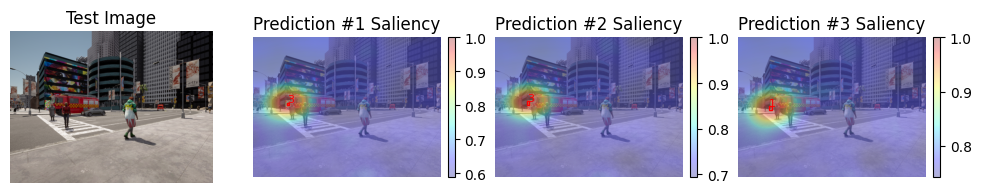

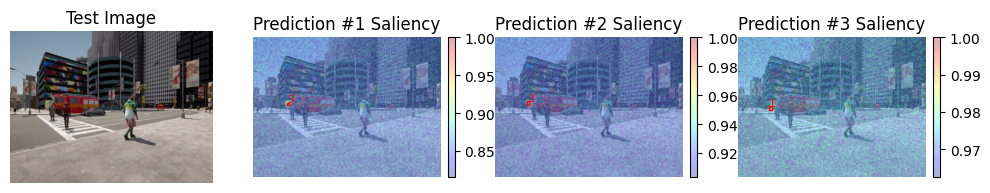

In [6]:
dets = list(detector([img]))[0]
ref_idxs = [0,1,9]
ref_dets = [list(dets)[idx] for idx in ref_idxs]
ref_bboxes, ref_scores, labels = dets_to_mats(ref_dets)
sal_maps = run_detect_saliency("DRISEStack",img,ref_bboxes,ref_scores)
visualize_saliency_plot(img,sal_maps,ref_bboxes,labels)
sal_maps = run_detect_saliency("RandomGridStack",img,ref_bboxes,ref_scores)
visualize_saliency_plot(img,sal_maps,ref_bboxes,labels)

### Benign Patch Saliency <a name="Generate-Saliency-Adversarial-Patch-XAITK-Armory"></a>

['person', 'vehicle', 'traffic light']
Saliency maps: (3, 960, 1280)
Prediction 1 saliency map range: [0.7639776905707542, 1.0]
Prediction 2 saliency map range: [0.7575848158189453, 1.0]
Prediction 3 saliency map range: [0.694529814170206, 1.0]
Saliency maps: (3, 960, 1280)
Prediction 1 saliency map range: [0.9870158152380107, 1.0]
Prediction 2 saliency map range: [0.9244774520884755, 1.0]
Prediction 3 saliency map range: [0.7417253021804158, 1.0]


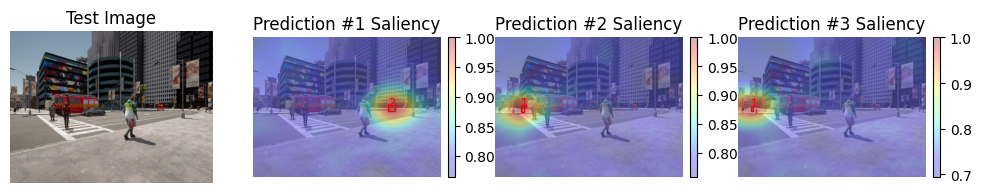

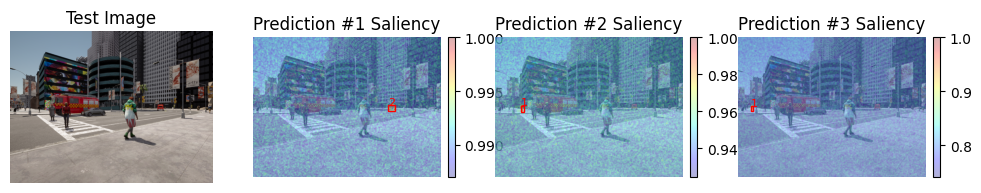

In [7]:
dets = list(detector([img_benign]))[0]
ref_idxs = [0,1,9]
ref_dets = [list(dets)[idx] for idx in ref_idxs]
ref_bboxes, ref_scores, labels = dets_to_mats(ref_dets)
sal_maps = run_detect_saliency("DRISEStack",img_benign,ref_bboxes,ref_scores)
visualize_saliency_plot(img,sal_maps,ref_bboxes,labels)
sal_maps = run_detect_saliency("RandomGridStack",img_benign,ref_bboxes,ref_scores)
visualize_saliency_plot(img,sal_maps,ref_bboxes,labels)